# 4.1 Graph Models

Here we provide some examples of Graph Models using SciPy.

Copyright:

In [13]:
# import libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D

## 1. Laplacian Matrix

In the cell below as we can see in the first 5 lines there is the representation of intitally calculating the degree matrix.

In [11]:
def unnormalized_laplacian(adj_matrix):
    # Calculate the degree matrix first
    R = np.sum(adj_matrix, axis=1)
    degreeMatrix = np.diag(R)
    return degreeMatrix - adj_matrix

def normalized_laplacian(adj_matrix):
    R = np.sum(adj_matrix, axis=1)
    R_sqrt = 1/np.sqrt(R)
    D_sqrt = np.diag(R_sqrt)
    I = np.eye(adj_matrix.shape[0])
    return I - D_sqrt * adj_matrix * D_sqrt

## 2. Adjacency Matrix

The cell below represents the adjacent output that will be displayed on the graph below, below that we also see what is to be what will be plotted as well as the generation on the graph itself.

In [14]:
# the adjacency matrix is output as a graph.
G = nx.Graph()

# Generate a directed graph
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_nodes_from([3, 4, 5, 6])
G.add_cycle([1, 2, 3, 4])
G.add_edge(1, 3)
G.add_edges_from([(3, 5), (3, 6), (6, 7)])
nx.draw(G)
plt.show()

# Generate a graph without direction
G = nx.complete_graph(5)
nx.draw(G)
plt.show()

AttributeError: ignored

## 3. Laplacian Eigenmaps

The cell below represents the data that will be utilized to plot on the graph below. By using the swiss roll dataset as well as the kernel function this all will be used in order to calculate the pairwise distance and finally the information is seen in the graph below.

eig_val[:10]:  [-1.12960833e-16  6.86973034e-04  7.75115650e-04  1.50338589e-03
  2.58298430e-03  2.88641653e-03  3.77825420e-03  4.15825157e-03
  5.24671619e-03  5.64754794e-03]
j:  1
[0.00068697 0.00077512]
[[4.92886200e+00 3.18440413e-12]
 [3.18434168e-12 4.85891337e+00]]


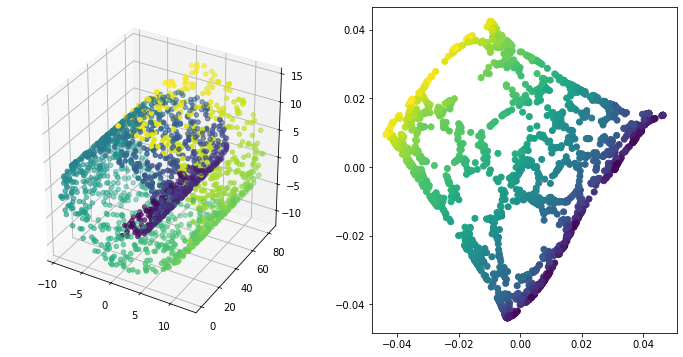

In [5]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

# rbf kernel function
def rbf(dist, t = 1.0):
    return np.exp(-(dist/t))

# calculate the Pairwise distance, x is matrix
# (a-b)^2 = a^2 + b^2 - 2*a*b
# returns the square of the distance between any two points
def cal_pairwise_dist(x):
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):
    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)
    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]
    return W

def le(data, n_dims = 2,
    n_neighbors = 5, t = 1.0):
    '''
    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    print("eig_val[:10]: ", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    X, Y = make_swiss_roll(n_samples = 2000)
    X_ndim = le(X, n_neighbors = 5, t = 20)

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)

    ax2 = fig.add_subplot(122)
    ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
    plt.show()

    # X = load_digits().data
    # y = load_digits().target
    #
    # dist = cal_pairwise_dist(X)
    # max_dist = np.max(dist)
    # print("max_dist", max_dist)
    # X_ndim = le(X, n_neighbors = 20, t = max_dist*0.1)
    # plt.scatter(X_ndim[:, 0], X_ndim[:, 1], c = y)
    # plt.savefig("LE2.png")
    # plt.show()